Text(0.5, 1.0, 'Correlation Matrix of Bill Amounts (April-Sep 2005)')

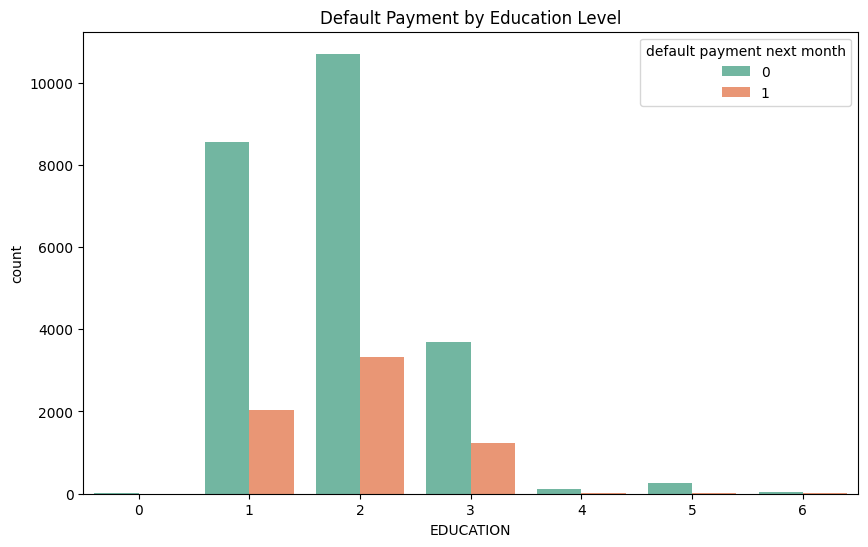

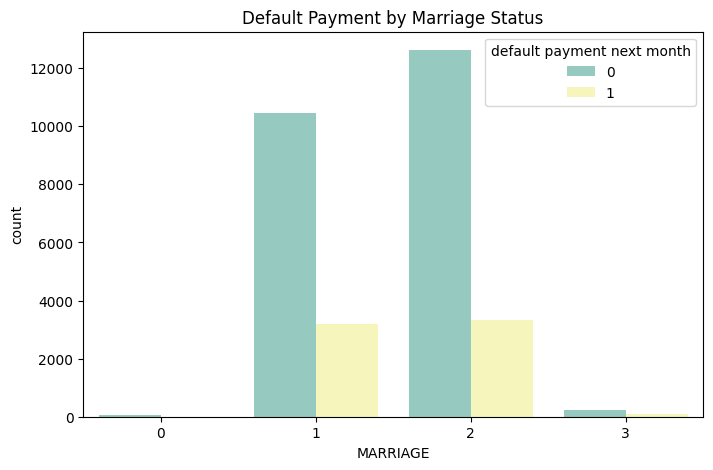

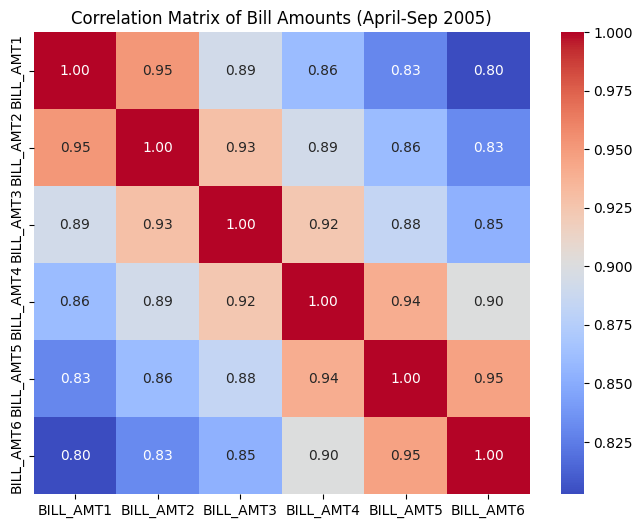

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
df = pd.read_csv('../data/raw/credit_default.csv', header = 1)

#visualiazation of default payment vs education level
# where EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='EDUCATION', hue='default payment next month', palette='Set2')
plt.title('Default Payment by Education Level') 

#visualization of default payment vs marriage status
#Where MARRIAGE: (1=married, 2=single, 3=others)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='MARRIAGE', hue='default payment next month', palette='Set3')
plt.title('Default Payment by Marriage Status')

#correlation matrix of the amount of bill statement in (april-sep 2005)
bill_amounts = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
corr_matrix = bill_amounts.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Bill Amounts (April-Sep 2005)')


In [ ]:
# finding which features are most important in predicting default payment
import pandas as pd
import numpy as np
import joblib
import os

# Load the model
model = joblib.load('../models/baseline_model.pkl')

# Load reference data to get feature names
reference_df = pd.read_csv('../data/processed/reference_data.csv')

# See feature importance
feature_importance = pd.DataFrame({
    'feature': reference_df.columns,
    'coefficient': np.abs(model.coef_[0])
}).sort_values('coefficient', ascending=False)

print(feature_importance.head(10))

      feature  coefficient
5       PAY_0     0.653654
11  BILL_AMT1     0.312812
18   PAY_AMT2     0.253532
17   PAY_AMT1     0.152160
0   LIMIT_BAL     0.116704
13  BILL_AMT3     0.106742
6       PAY_2     0.104018
2   EDUCATION     0.096321
7       PAY_3     0.086926
3    MARRIAGE     0.078764


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib  # For saving the model

# ===== 1. Load the CSV =====
df = pd.read_csv('../data/raw/credit_default.csv', header = 1)

# Quick look
print("Data shape:", df.shape)
print(df.head())

# ===== 2. Basic Cleaning =====
# Drop ID column if it exists
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Fill missing numeric values with column mean (if any)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# ===== 3. Define Features & Target =====
# Typical target column for this dataset
target_col = 'default payment next month'
X = df.drop(columns=[target_col])
y = df[target_col]

# ===== 4. Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===== 5. Scale Numeric Features =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ===== 6. Train Logistic Regression =====
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# ===== 7. Evaluate Model =====
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
# ===== 8. Save Artifacts =====
# ===== 8. Save Artifacts =====
import os

# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Save model and scaler
joblib.dump(model, '../models/baseline_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

# Save reference data (features only)
reference_df = pd.DataFrame(X_test, columns=X.columns)
reference_df.to_csv('../data/processed/reference_data.csv', index=False)

# Save reference data WITH labels (this is the new part you need)
reference_with_labels = pd.DataFrame(X_test, columns=X.columns)
reference_with_labels['default payment next month'] = y_test.values
reference_with_labels.to_csv('../data/processed/reference_with_labels.csv', index=False)

print("Saved model, scaler, and reference data (with labels)")


Data shape: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
